In [29]:
# ALLEGHENY DATASET ANALYSIS, GROUP 69
    # Andy Thai           - A12112599
    # Johnson Pang        -
    # Ronald Baldonado    - A11948171
    # Haoyuan Wang        -

# Introduction and Background:

Preventing and understanding the underlying causes of car accidents continues to be a key public safety issue. Car accidents remain commonplace throughout the United States, retaining its status as a significant cause of death. Thus, it is important that this issue be studied as to further prevent deaths and property damage.
 
Analysts point to a myriad of reasons as to why car accidents occur. According to the Critical Reasons for Crashes Investigated in the National Motor Vehicle Crash Causation Survey (2015), for the 5470 weighted samples, about 50% of the critical reasons for car crashes involve slick roads (loose debris, ice, etc), while fog/rain/snow are involved in around 4% of crashes. Note, however, that these given reasons are not the “primary causes” of the car crashes, just the “immediate reason for the critical pre-crash event and is often the last failure in the causal chain of events leading up to the crash.”
 
In addition, according to the Road Weather Management Program’s “How Do Weather Events Impact Roads?”, precipitation and fog causes a lessens vehicle traction and environmental visibility. The website also states that 22% of crashes from 2005-2014 involve poor weather, including slick road conditions. Wet pavement, rain, and snow/sleet are involved in 73%, 46% and 17%, of weather related crashes, respectively

<h3>Hypothesis:</h3>

Given this background information, we hope to find patterns of interest between weather, environmental conditions and poor driving, in regards to injury severity and and the amount of injuries within crashes in Allegheny. By analyzing these patterns, we hope to provide more insight into car accidents and contribute to preventing more unnecessary destruction.

In [30]:
# General import statements
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# SciPy
import scipy.stats as stats
from scipy.stats import normaltest

# Statmodels & patsy
import patsy
import statsmodels.api as sm

# Gmaps API
import gmaps
api = ""
gmaps.configure(api_key=api)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Description
The dataset we will be using for our project will be taken directly from <https://catalog.data.gov/dataset/allegheny-county-crash-data>. 

Specifically, the “2016 Allegheny County Crash Data” is a sizeable dataset with 187 features for each observation including the latitude and longitude location of the crash, the street name, the weather conditions, and various other driving/driver conditions that may contribute to the car crash occurring. The total amount of observations within the 2016 data is about 12,900 observations throughout the year. 

In [31]:
# 2016 crash data
url_2016 = 'https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/9ccea350-e062-45e2-ade5-45e9378f40d2/download/reordered2016crashes.csv'

# 2004 - 2016 crash data
# Not used but here for potential reference
url_all = 'https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/2c13021f-74a9-4289-a1e5-fe0472c89881/download/all-crashes2004-2016.csv'

# Load dataframe
df_original = pd.read_csv(url_2016)

# Data Cleaning and Preprocessing
Before we do any work on the data, we must determine what categories that may be of relevant interest to our analysis. We refer to the data dictionary (provided at: <https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/4df9a3c6-34c1-45a5-936e-80758f9f38a5/download/allegheny-county-crash-data-dictionary.pdf>) to find out what each category's definition and the meanings of their corresponding values.


We separate potentially useful categories by relation for indexing below, and combine them all into a final trimmed dataset containing only the categories we deem of interest. Then, we drop the null data values.

We aim to use the MAX_SEVERITY_LEVEL category. However, the values are not sorted in ascending order; the values go by:

0 - Not injured

1 - Killed

2 - Major injury

3 - Moderate injury

4 - Minor injury

8 - Injury/ Unknown Severity

9 - Unknown


We rectify this issue by reordering the values so they match the following schema:

0 - Not injured

1 - Minor injury

2 - Moderate injury

3 - Major injury

4 - Killed

8 - Injury/ Unknown Severity

9 - Unknown

In [32]:
# Create related categories for indexing
category_time = ["CRASH_YEAR", "CRASH_MONTH", "TIME_OF_DAY", "HOUR_OF_DAY"]

category_conditions = ["ILLUMINATION", "WEATHER", "ROAD_CONDITION"]

category_type = ["COLLISION_TYPE", "URBAN_RURAL"]

category_people_count = ["PERSON_COUNT", "VEHICLE_COUNT"] 

category_injury = ["FATAL_COUNT", "INJURY_COUNT", "MAJ_INJ_COUNT", "MOD_INJ_COUNT", "MIN_INJ_COUNT", \
                   "UNK_INJ_DEG_COUNT", "MAX_SEVERITY_LEVEL", "FATAL_OR_MAJ_INJ"]

category_belt = ["UNBELTED", "UNBELTED_OCC_COUNT", "UNB_DEATH_COUNT", "UNB_MAJ_INJ_COUNT", "BELTED_DEATH_COUNT", \
                 "BELTED_MAJ_INJ_COUNT"]

category_age = ["DRIVER_COUNT_16YR", "DRIVER_COUNT_17YR", "DRIVER_COUNT_18YR", "DRIVER_COUNT_19YR", \
                "DRIVER_COUNT_20YR", "DRIVER_COUNT_50_64YR", "DRIVER_COUNT_65_74YR", "DRIVER_COUNT_75PLUS"]

category_location = ["LATITUDE", "LONGITUDE", "DEC_LAT", "DEC_LONG", "STREET_NAME"]

category_alcohol = ["ALCOHOL_RELATED", "DRINKING_DRIVER", "UNDERAGE_DRNK_DRV", "IMPAIRED_DRIVER"]

category_attention = ["CELL_PHONE", "DISTRACTED", "FATIGUE_ASLEEP"]

category_speed = ["LIMIT_65MPH", "SPEEDING", "SPEEDING_RELATED", "AGGRESSIVE_DRIVING"]

# Combine all categories
categories_all = category_time + category_conditions + category_type + category_people_count + \
                category_injury + category_belt + category_age + category_location + \
                category_alcohol + category_attention + category_speed

# Trim original dataframe into relevant data
df_trimmed = df_original[categories_all]

In [33]:
# Drop null values
df_trimmed.dropna()

# Reorder severity levels in ascending order
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(1, 5)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(4, 1)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(5, 4)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(2, 5)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(3, 2)
df_trimmed['MAX_SEVERITY_LEVEL'] = df_trimmed['MAX_SEVERITY_LEVEL'].replace(5, 3)

# Data Visualization
Below we will run code on our data and visualize the information into a more visually readable format.


<h3>Google Maps Heatmap</h3>

The code below outputs a Google Maps heatmap of the latitudes and longitudes of all of the crash locations within the dataset. 

This is accomplished via the gmaps API located at <https://github.com/pbugnion/gmaps>. 

In [34]:
# Get latitudes and longitudes of accident locations
df_location = df_trimmed[category_location]
df_location_dec = df_location[['DEC_LAT','DEC_LONG']]
loc_series = df_location_dec.as_matrix(['DEC_LAT','DEC_LONG'])

# Do not plot NaN values on gmaps
loc_list = []
for i in loc_series:
    if( not math.isnan(i[0]) and not math.isnan(i[1])):
        loc_list.append((i[0],i[1]))

# Create gmaps figure and show
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(loc_list)
fig.add_layer(heatmap_layer)
fig

Widget Javascript not detected.  It may not be installed or enabled properly.


The above code may not display a gmaps figure when viewed on GitHub. 

Attached below are screenshots of the gmaps figure.

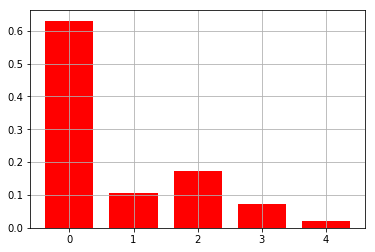

In [35]:
# Get drinking categories
df_isDrunk = df_trimmed[category_alcohol + category_injury]
df_isDrunk = df_isDrunk[["DRINKING_DRIVER","MAX_SEVERITY_LEVEL"]]

# Get if driver was drunk
df_Drunk = df_isDrunk[df_isDrunk['DRINKING_DRIVER'] == 1]
df_Drunk = df_Drunk[df_Drunk['MAX_SEVERITY_LEVEL'] <= 4]

# Plot
graphDrunk = df_Drunk["MAX_SEVERITY_LEVEL"].hist(bins=range(0,6), align='left', rwidth=0.75, color='red', normed=1)
plt.show()

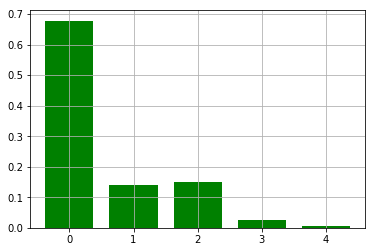

In [36]:
# Plots not drunk histogram
df_NotDrunk = df_isDrunk[df_isDrunk["DRINKING_DRIVER"] == 0]
graphNotDrunk = df_NotDrunk["MAX_SEVERITY_LEVEL"].hist(bins=range(0,6), align='left', rwidth=0.75, color='green', normed=1)
plt.show()

In [37]:
# Runs linear classifier / t-test on data
outcome, predictors = patsy.dmatrices('MAX_SEVERITY_LEVEL ~ DRINKING_DRIVER', df_isDrunk)

# Use statsmodels to intialize the OLS model
mod = sm.OLS(outcome, predictors)

# Fit the model
res = mod.fit()

# Show results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     MAX_SEVERITY_LEVEL   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7288
Date:                Tue, 13 Jun 2017   Prob (F-statistic):              0.393
Time:                        17:44:18   Log-Likelihood:                -33577.
No. Observations:               12900   AIC:                         6.716e+04
Df Residuals:                   12898   BIC:                         6.717e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           2.2196      0.030     

In [38]:
# Create dataframe for weather and injuries
df_weather = df_trimmed[category_conditions + category_injury]

In [39]:
# Injury count with weather
df_weather_inj = df_weather[['WEATHER','INJURY_COUNT']]

# Calculate means for injury count
df_weather_mean_inj = []
df_weather_1_mean_inj =  df_weather[df_weather['WEATHER'] == 1]['INJURY_COUNT'].mean() # Good weather conditions 
df_weather_2_mean_inj =  df_weather[df_weather['WEATHER'] == 2]['INJURY_COUNT'].mean() # Rain
df_weather_3_mean_inj =  df_weather[df_weather['WEATHER'] == 3]['INJURY_COUNT'].mean() # Hail
df_weather_4_mean_inj =  df_weather[df_weather['WEATHER'] == 4]['INJURY_COUNT'].mean() # Snow
df_weather_5_mean_inj =  df_weather[df_weather['WEATHER'] == 5]['INJURY_COUNT'].mean() # Fog
df_weather_6_mean_inj =  df_weather[df_weather['WEATHER'] == 6]['INJURY_COUNT'].mean() # Rain and fog
df_weather_7_mean_inj =  df_weather[df_weather['WEATHER'] == 7]['INJURY_COUNT'].mean() # Hail and fog

# Append to list for injury
df_weather_mean_inj.append(df_weather_1_mean_inj)
df_weather_mean_inj.append(df_weather_2_mean_inj)
df_weather_mean_inj.append(df_weather_3_mean_inj)
df_weather_mean_inj.append(df_weather_4_mean_inj)
df_weather_mean_inj.append(df_weather_5_mean_inj)
df_weather_mean_inj.append(df_weather_6_mean_inj)
df_weather_mean_inj.append(df_weather_7_mean_inj)

# Show mean number of injuries per weather condition
df_weather_mean_inj

[0.592750331251183,
 0.5340909090909091,
 0.39436619718309857,
 0.3852813852813853,
 0.4594594594594595,
 0.3157894736842105,
 0.23076923076923078]

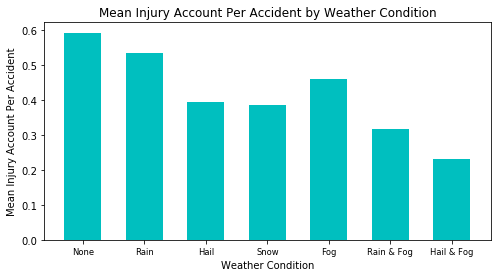

In [40]:
#Bar Graph of ratios of aggressive driving per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = df_weather_mean_inj
plt.figure(figsize=(8,4))
weather_mean_inj_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Mean Injury Account Per Accident by Weather Condition")
plt.ylabel('Mean Injury Account Per Accident')
plt.xlabel('Weather Condition')
plt.show()

In [41]:
# Max injury severity level with weather
df_weather_sev = df_weather[['WEATHER', 'MAX_SEVERITY_LEVEL']]
df_weather_sev = df_weather_sev[df_weather_sev['MAX_SEVERITY_LEVEL'] <= 4] # Severity level 8-9 is unknown and redundant

# Calculate means for max severity
df_weather_mean_sev = []
df_weather_1_mean_sev =  df_weather[df_weather['WEATHER'] == 1]['MAX_SEVERITY_LEVEL'].mean() # Good weather conditions 
df_weather_2_mean_sev =  df_weather[df_weather['WEATHER'] == 2]['MAX_SEVERITY_LEVEL'].mean() # Rain
df_weather_3_mean_sev =  df_weather[df_weather['WEATHER'] == 3]['MAX_SEVERITY_LEVEL'].mean() # Hail
df_weather_4_mean_sev =  df_weather[df_weather['WEATHER'] == 4]['MAX_SEVERITY_LEVEL'].mean() # Snow
df_weather_5_mean_sev =  df_weather[df_weather['WEATHER'] == 5]['MAX_SEVERITY_LEVEL'].mean() # Fog
df_weather_6_mean_sev =  df_weather[df_weather['WEATHER'] == 6]['MAX_SEVERITY_LEVEL'].mean() # Rain and fog
df_weather_7_mean_sev =  df_weather[df_weather['WEATHER'] == 7]['MAX_SEVERITY_LEVEL'].mean() # Hail and fog

# Append to list for max severity
df_weather_mean_sev.append(df_weather_1_mean_sev)
df_weather_mean_sev.append(df_weather_2_mean_sev)
df_weather_mean_sev.append(df_weather_3_mean_sev)
df_weather_mean_sev.append(df_weather_4_mean_sev)
df_weather_mean_sev.append(df_weather_5_mean_sev)
df_weather_mean_sev.append(df_weather_6_mean_sev)
df_weather_mean_sev.append(df_weather_7_mean_sev)

# Show mean maximum injury severity level per weather condition
df_weather_mean_sev

[2.287999242854439,
 2.099242424242424,
 1.591549295774648,
 1.8167388167388168,
 1.1891891891891893,
 1.4736842105263157,
 1.8461538461538463]

In [42]:
# Create dataframe for weather with aggressive driving
df_weather_speed = df_trimmed[category_conditions + category_speed]

In [43]:
# Weather with aggressive driving
df_weather_aggressive = df_weather_speed[['WEATHER','AGGRESSIVE_DRIVING']]

# Calculate aggressive ratios
df_weather_agg_ratio = []

# Aggressive driving for good weather conditions
df_weather_1_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 1]['AGGRESSIVE_DRIVING'] 
df_weather_1_agg_ratio = df_weather_1_agg.value_counts()[1] / (df_weather_1_agg.value_counts()[0] + df_weather_1_agg.value_counts()[1])

# Aggressive driving for rainy weather conditions
df_weather_2_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 2]['AGGRESSIVE_DRIVING'] 
df_weather_2_agg_ratio = df_weather_2_agg.value_counts()[1] / (df_weather_2_agg.value_counts()[0] + df_weather_2_agg.value_counts()[1])

# Aggressive driving for hailing weather conditions
df_weather_3_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 3]['AGGRESSIVE_DRIVING'] 
df_weather_3_agg_ratio = df_weather_3_agg.value_counts()[1] / (df_weather_3_agg.value_counts()[0] + df_weather_3_agg.value_counts()[1])

# Aggressive driving for snowy weather conditions
df_weather_4_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 4]['AGGRESSIVE_DRIVING'] 
df_weather_4_agg_ratio = df_weather_4_agg.value_counts()[1] / (df_weather_4_agg.value_counts()[0] + df_weather_4_agg.value_counts()[1])

# Aggressive driving for foggy weather conditions
df_weather_5_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 5]['AGGRESSIVE_DRIVING'] 
df_weather_5_agg_ratio = df_weather_5_agg.value_counts()[1] / (df_weather_5_agg.value_counts()[0] + df_weather_5_agg.value_counts()[1])

# Aggressive driving for rainy and foggy weather conditions
df_weather_6_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 6]['AGGRESSIVE_DRIVING'] 
df_weather_6_agg_ratio = df_weather_6_agg.value_counts()[1] / (df_weather_6_agg.value_counts()[0] + df_weather_6_agg.value_counts()[1])

# Aggressive driving for hailing and foggy weather conditions
df_weather_7_agg = df_weather_aggressive[df_weather_aggressive['WEATHER'] == 7]['AGGRESSIVE_DRIVING'] 
df_weather_7_agg_ratio = df_weather_7_agg.value_counts()[1] / (df_weather_7_agg.value_counts()[0] + df_weather_7_agg.value_counts()[1])

# Append to list
df_weather_agg_ratio.append(df_weather_1_agg_ratio)
df_weather_agg_ratio.append(df_weather_2_agg_ratio)
df_weather_agg_ratio.append(df_weather_3_agg_ratio)
df_weather_agg_ratio.append(df_weather_4_agg_ratio)
df_weather_agg_ratio.append(df_weather_5_agg_ratio)
df_weather_agg_ratio.append(df_weather_6_agg_ratio)
df_weather_agg_ratio.append(df_weather_7_agg_ratio)

# Print out ratios per weather condition
df_weather_agg_ratio

[0.48485708877531708,
 0.55227272727272725,
 0.46478873239436619,
 0.46897546897546899,
 0.48648648648648651,
 0.42105263157894735,
 0.38461538461538464]

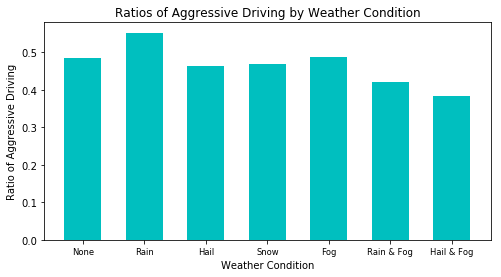

In [44]:
#Bar Graph of ratios of aggressive driving per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = df_weather_agg_ratio
plt.figure(figsize=(8,4))
weather_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Ratios of Aggressive Driving by Weather Condition")
plt.ylabel('Ratio of Aggressive Driving')
plt.xlabel('Weather Condition')
plt.show()

In [45]:
# Weather with speeding
df_weather_speeding = df_weather_speed[['WEATHER','SPEEDING']]
NUM_WEATHER_COND = 7; #ignore conditions (8: other, 9: unknown)

# Calculate speeding ratios (speeding vs total)
weather_spd_ratios = [0 for i in range(NUM_WEATHER_COND)]

for i in range(1,NUM_WEATHER_COND + 1):
    weather_spd = df_weather_speeding[df_weather_speeding['WEATHER'] == i]['SPEEDING']
    df_vc = weather_spd.value_counts() #counts the number of 0s for no speeding, 1s for speeding
    df_vc_idx = df_vc.index.tolist() #gets the values: [0, 1] in this case
    if len(df_vc) > 1:
        ratio = df_vc[1]/(df_vc[0] + df_vc[1]) #ratio of speeding vs total
    else:
        if df_vc_idx[0] == 0: #all accidents non speeding
            ratio = 0;
        else:
            ratio = 1; #all accidents speeding
    print("CONDITION: ", i)
    print(df_vc) #print the value counts
    weather_spd_ratios[i-1] = ratio

# Print out ratios per weather condition
weather_spd_ratios

CONDITION:  1
0    10151
1      415
Name: SPEEDING, dtype: int64
CONDITION:  2
0    1283
1      37
Name: SPEEDING, dtype: int64
CONDITION:  3
0    69
1     2
Name: SPEEDING, dtype: int64
CONDITION:  4
0    685
1      8
Name: SPEEDING, dtype: int64
CONDITION:  5
0    37
Name: SPEEDING, dtype: int64
CONDITION:  6
0    19
Name: SPEEDING, dtype: int64
CONDITION:  7
0    13
Name: SPEEDING, dtype: int64


[0.03927692598902139,
 0.02803030303030303,
 0.028169014084507043,
 0.011544011544011544,
 0,
 0,
 0]

When determining the ratios above, we found that they were 0 in some cases. Taking a look at the value counts, we discovered that for certain weather conditions such as 5, 6, 7 (Fog, Rain & Fog, Hail & Fog respectively) had a very small number of accidents. Even under 30 accidents in two cases. So their ratios being 0 may not be entirely accurate. Even hail had a relatively small number of 69 with respect to the general range of the ratios (all being under 4%). Nonetheless, there does seem to be a trend of a lower tendency for speeding-related accidents.

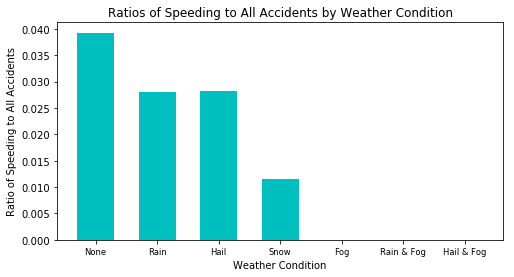

In [46]:
#Bar Graph of ratios of speeding per weather condition
x_lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
y = weather_spd_ratios
plt.figure(figsize=(8,4))
weather_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title("Ratios of Speeding to All Accidents by Weather Condition")
plt.ylabel('Ratio of Speeding to All Accidents')
plt.xlabel('Weather Condition')
plt.show()

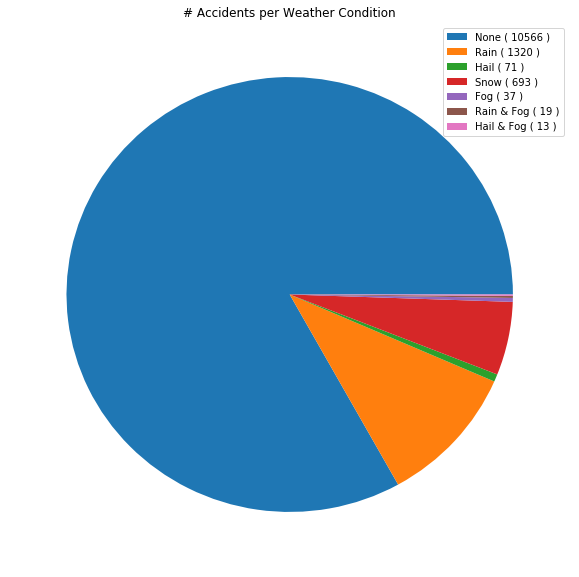

In [47]:
#calculate weather counts
df_weather = df_weather_speed[df_weather_speed['WEATHER'] <= 7] #ignore conditions 8, 9
weather_counts = df_weather['WEATHER'].value_counts().sort_index()

#Pie Graph of # of accidents per weather condition
lbls = ['None','Rain', 'Hail', 'Snow', 'Fog', 'Rain & Fog', 'Hail & Fog']
total_count = sum(weather_counts)
#appends the values to lbls (since some pie slices too small to see)
for i in range(len(lbls)):
    #lbls[i] += " (" + str('%0.2f' % (weather_counts[i+1]/total_count * 100)) + "%)" #percentages
    lbls[i] += " ( " + str(weather_counts[i+1]) + " )" #counts
    
y = weather_counts
plt.figure(figsize=(8,8));
fig, ax = plt.subplots();
patches, texts = ax.pie(y);
plt.legend(patches, lbls);
plt.title("# Accidents per Weather Condition")
fig.set_size_inches(10,10);
plt.show()

In [48]:
# Create dataframe for illumination conditions with injury counts
df_light = df_trimmed[category_conditions + category_injury]
df_light = df_light[['ILLUMINATION','INJURY_COUNT']]

# Calculate mean injury counts per lighting condition
df_light_mean = []
df_light_1_mean =  df_light[df_light['ILLUMINATION']==1]['INJURY_COUNT'].mean() # Daylight
df_light_2_mean =  df_light[df_light['ILLUMINATION']==2]['INJURY_COUNT'].mean() # Dark - no street light
df_light_3_mean =  df_light[df_light['ILLUMINATION']==3]['INJURY_COUNT'].mean() # Dark - street light
df_light_4_mean =  df_light[df_light['ILLUMINATION']==4]['INJURY_COUNT'].mean() # Dusk
df_light_5_mean =  df_light[df_light['ILLUMINATION']==5]['INJURY_COUNT'].mean() # Dawn
df_light_6_mean =  df_light[df_light['ILLUMINATION']==6]['INJURY_COUNT'].mean() # Dark - unknown roadway lighting

# Append means to list
df_light_mean.append(df_light_1_mean)
df_light_mean.append(df_light_2_mean)
df_light_mean.append(df_light_3_mean)
df_light_mean.append(df_light_4_mean)
df_light_mean.append(df_light_5_mean)
df_light_mean.append(df_light_6_mean)

# Print means per lighting condition
df_light_mean

[0.6070865186263803,
 0.4595744680851064,
 0.517541316323572,
 0.5799086757990868,
 0.48258706467661694,
 0.5555555555555556]

In [49]:
# Aggressive driving with illumination
df_ill_aggressive = df_weather_speed[['ILLUMINATION','AGGRESSIVE_DRIVING']]

# Calculate aggression with illumination
df_ill_agg_ratio = []

# Aggressive driving for daytime conditions
df_ill_1_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 1]['AGGRESSIVE_DRIVING'] 
df_ill_1_agg_ratio = df_ill_1_agg.value_counts()[1] / (df_ill_1_agg.value_counts()[0] + df_ill_1_agg.value_counts()[1])

# Aggressive driving for dark, no street light conditions
df_ill_2_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 2]['AGGRESSIVE_DRIVING'] 
df_ill_2_agg_ratio = df_ill_2_agg.value_counts()[1] / (df_ill_2_agg.value_counts()[0] + df_ill_2_agg.value_counts()[1])

# Aggressive driving for dark, with street light conditions
df_ill_3_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 3]['AGGRESSIVE_DRIVING'] 
df_ill_3_agg_ratio = df_ill_3_agg.value_counts()[1] / (df_ill_3_agg.value_counts()[0] + df_ill_3_agg.value_counts()[1])

# Aggressive driving for dusk conditions
df_ill_4_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 4]['AGGRESSIVE_DRIVING'] 
df_ill_4_agg_ratio = df_ill_4_agg.value_counts()[1] / (df_ill_4_agg.value_counts()[0] + df_ill_4_agg.value_counts()[1])

# Aggressive driving for dawn conditions
df_ill_5_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 5]['AGGRESSIVE_DRIVING'] 
df_ill_5_agg_ratio = df_ill_5_agg.value_counts()[1] / (df_ill_5_agg.value_counts()[0] + df_ill_5_agg.value_counts()[1])

# Aggressive driving for dark, unknown conditions
df_ill_6_agg = df_ill_aggressive[df_ill_aggressive['ILLUMINATION'] == 6]['AGGRESSIVE_DRIVING'] 
df_ill_6_agg_ratio = df_ill_6_agg.value_counts()[1] / (df_ill_6_agg.value_counts()[0] + df_ill_6_agg.value_counts()[1])

# Append to list
df_ill_agg_ratio.append(df_ill_1_agg_ratio)
df_ill_agg_ratio.append(df_ill_2_agg_ratio)
df_ill_agg_ratio.append(df_ill_3_agg_ratio)
df_ill_agg_ratio.append(df_ill_4_agg_ratio)
df_ill_agg_ratio.append(df_ill_5_agg_ratio)
df_ill_agg_ratio.append(df_ill_6_agg_ratio)

# Print out ratios per illumination condition
df_ill_agg_ratio

[0.52323747118068198,
 0.39432624113475179,
 0.42853000869817337,
 0.53881278538812782,
 0.40298507462686567,
 0.37037037037037035]

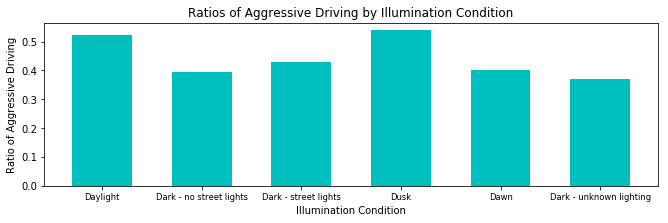

In [50]:
#Bar Graph of ratios of aggressive driving per illumination condition
x_lbls = ['Daylight','Dark - no street lights', 'Dark - street lights', 'Dusk', 'Dawn', 'Dark - unknown lighting']
y = df_ill_agg_ratio
plt.figure(figsize=(11,3))
ill_agg_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title('Ratios of Aggressive Driving by Illumination Condition')
plt.ylabel('Ratio of Aggressive Driving')
plt.xlabel('Illumination Condition')
plt.show()

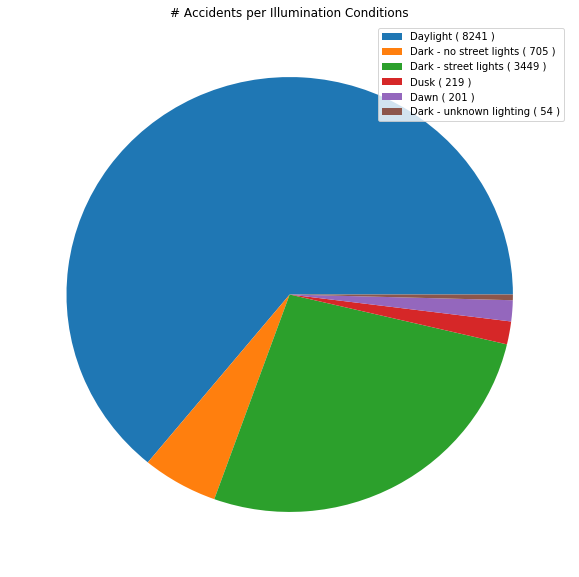

In [51]:
#grab illumination counts
df_illum = df_weather_speed[df_weather_speed['ILLUMINATION'] <= 6] #exclude other, uknown illumination conditions
illum_counts = df_illum['ILLUMINATION'].value_counts().sort_index()

#Pie Graph of # of occurrences per weather condition
lbls = ['Daylight','Dark - no street lights', 'Dark - street lights', 'Dusk', 'Dawn', 'Dark - unknown lighting']
total_count = sum(illum_counts)
#appends the percentage values to lbls (since some %s too small to see)
for i in range(len(lbls)):
    #lbls[i] += " (" + str('%0.2f' % (illum_counts[i+1]/total_count * 100)) + "%)" #percentages
    lbls[i] += " ( " + str(illum_counts[i+1]) + " )" #values


y = illum_counts
fig, ax = plt.subplots();
patches, texts = ax.pie(y);
plt.legend(patches, lbls);
plt.title("# Accidents per Illumination Conditions")
fig.set_size_inches(10,10);
plt.show()

In [52]:
# Create dataframe for weather with month
df_weather_time = df_trimmed[category_conditions + category_time]

In [53]:
df_month = df_weather_time[['CRASH_MONTH']]
NUM_MONTH = 12;

# Calculate speeding ratios (speeding vs total)
month_counts = df_month['CRASH_MONTH'].value_counts().sort_index()

# Print out ratios per weather condition
month_counts

1     1305
2     1006
3      904
4     1035
5     1038
6     1044
7      973
8     1091
9     1017
10    1149
11    1072
12    1266
Name: CRASH_MONTH, dtype: int64

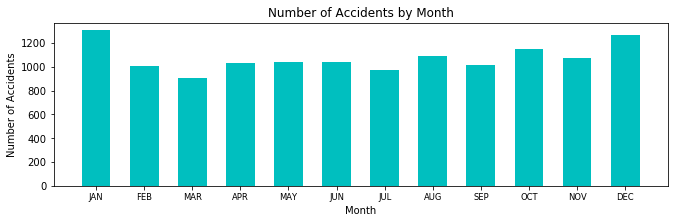

In [54]:
x_lbls = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
y = month_counts
plt.figure(figsize=(11,3))
month_count_plt = plt.bar(range(1, len(x_lbls) + 1), y, width=0.6, color='c')
plt.xticks(range(1,len(x_lbls) + 1), x_lbls, size='small')
plt.title('Number of Accidents by Month')
plt.ylabel('Number of Accidents')
plt.xlabel('Month')
plt.show()

# Data Analysis and Results:

# Conclusion/Discussion: